<a href="https://colab.research.google.com/github/nebuus/fun/blob/extra/Simple_NN_for_Gaussian_fit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.animation as animation  # this is needed for the animation API
import matplotlib.image as mpimg # for grayscale input image
from matplotlib.colors import Normalize   # this is needed to rescale the color during the simulation

In [86]:
def get_initial_configuration(N, random_influence=0.2):
    """
    Initialize a concentration configuration. N is the side length
    of the (N x N)-sized grid.
    `random_influence` describes how much noise is added.
    """

    # We start with a configuration where on every grid cell
    # there's a lot of chemical A, so the concentration is high
    AA = (1-random_influence) * np.ones((N,N)) + random_influence * np.random.random((N,N))

    # Let's assume there's only a bit of B everywhere
    BB = random_influence * np.random.random((N,N))

    return AA, BB

In [3]:
def draw(A,B):
    """draw the concentrations"""
    %matplotlib inline
    plt.clf()
    fig, ax = plt.subplots(1,2,figsize=(5.65,4))
    ax[0].imshow(A, cmap='Greys')
    ax[1].imshow(B, cmap='Greys')
    ax[0].set_title('A')
    ax[1].set_title('B')
    ax[0].axis('off')
    ax[1].axis('off')

    plt.show()

In [91]:
A_init, B_init = get_initial_configuration(200)

In [92]:
A_init

array([[0.94224874, 0.83239191, 0.98276714, ..., 0.81759798, 0.85788884,
        0.80565263],
       [0.96181049, 0.87643627, 0.86354351, ..., 0.96027522, 0.91711047,
        0.98355841],
       [0.91891543, 0.81580969, 0.83596267, ..., 0.80333137, 0.87197208,
        0.98004181],
       ...,
       [0.83842843, 0.84203901, 0.95738983, ..., 0.89246535, 0.85724382,
        0.93208792],
       [0.9895783 , 0.88894696, 0.82935733, ..., 0.88222503, 0.89013101,
        0.98726538],
       [0.87306237, 0.8381073 , 0.86484957, ..., 0.90035431, 0.97271409,
        0.8189384 ]])

In [93]:
%matplotlib inline

In [95]:
def discrete_laplacian1(M):
    """Get the discrete Laplacian of matrix M"""
    L = -4*M
    L += np.roll(M, (0, 1), (0, 1))  # right neighbor
    L += np.roll(M, (0, -1), (0, 1))  # left neighbor
    L += np.roll(M, (-1, 0), (0, 1))  # top neighbor
    L += np.roll(M, (1, 0), (0, 1))  # bottom neighbor

    return L

def gray_scott_update1(A, B, DA, DB, f, k, delta_t):
    """
    Updates a concentration configuration according to a Gray-Scott model
    with diffusion coefficients DA and DB, as well as feed rate f and
    kill rate k.
    """
    #A, B = torch.tensor(A.detach().cpu().numpy()), torch.tensor(B.detach().cpu().numpy())

    # Let's get the discrete Laplacians first
    LA = discrete_laplacian1(A)
    LB = discrete_laplacian1(B)

    # Now apply the update formula
    diff_A = (DA*LA - A*B**2 + f*(1-A)) * delta_t
    diff_B = (DB*LB + A*B**2 - (k+f)*B) * delta_t

    A_res = A + diff_A
    B_res = B + diff_B

    return A_res, B_res

[[0.94224874 0.83239191 0.98276714 ... 0.81759798 0.85788884 0.80565263]
 [0.96181049 0.87643627 0.86354351 ... 0.96027522 0.91711047 0.98355841]
 [0.91891543 0.81580969 0.83596267 ... 0.80333137 0.87197208 0.98004181]
 ...
 [0.83842843 0.84203901 0.95738983 ... 0.89246535 0.85724382 0.93208792]
 [0.9895783  0.88894696 0.82935733 ... 0.88222503 0.89013101 0.98726538]
 [0.87306237 0.8381073  0.86484957 ... 0.90035431 0.97271409 0.8189384 ]]


<Figure size 640x480 with 0 Axes>

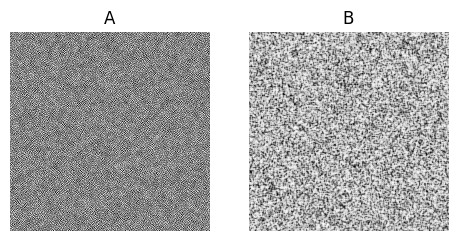

In [110]:
# update in time
delta_t = 3.0

# simulation steps
N_simulation_steps = 1

DA, DB, f, k = 0.14, 0.06, 0.040, 0.062 # bacteria
for t in range(N_simulation_steps):
    A_target, B_target = gray_scott_update1(A_init, B_init, DA, DB, f, k, delta_t)
    print(f'{A_init}')

draw(A_target,B_target)

In [99]:
def discrete_laplacian(M):
    """Get the discrete Laplacian of matrix M"""
    L = -4 * M
    L += torch.roll(M, (0, 1), (0, 1))  # right neighbor
    L += torch.roll(M, (0, -1), (0, 1))  # left neighbor
    L += torch.roll(M, (-1, 0), (0, 1))  # top neighbor
    L += torch.roll(M, (1, 0), (0, 1))  # bottom neighbor

    return L

def gray_scott_update(A, B, DA, DB, f, k, delta_t):
    """
    Updates a concentration configuration according to a Gray-Scott model
    with diffusion coefficients DA and DB, as well as feed rate f and
    kill rate k.
    """
    # Let's get the discrete Laplacians first
    LA = discrete_laplacian(A.detach())
    LB = discrete_laplacian(B.detach())

    # Now apply the update formula
    diff_A = (DA * LA - A * B**2 + f * (1 - A)) * delta_t
    diff_B = (DB * LB + A * B**2 - (k + f) * B) * delta_t

    A_updated = A + diff_A
    B_updated = B + diff_B

    return A_updated, B_updated

In [100]:
# Define a neural network to learn f and k
class GrayScottModel(nn.Module):
    def __init__(self):
        super(GrayScottModel, self).__init__()
        self.f = nn.Parameter(torch.tensor(0.03,requires_grad=True))
        self.k = nn.Parameter(torch.tensor(0.06, requires_grad=True))

    def forward(self, A, B, DA, DB, delta_t):
        f_clamped = torch.sigmoid(self.f)
        k_clamped = torch.sigmoid(self.k)
        A_pred, B_pred = gray_scott_update(A, B, DA, DB, f_clamped, k_clamped, delta_t)
        return A_pred, B_pred

In [101]:
A_tensor = torch.tensor(A_init, dtype=torch.float32, requires_grad=True)
B_tensor = torch.tensor(B_init, dtype=torch.float32, requires_grad=True)

A_target_tensor = torch.tensor(A_target, dtype=torch.float32, requires_grad=True)
B_target_tensor = torch.tensor(B_target, dtype=torch.float32, requires_grad=True)

In [102]:
# Instantiate the model, set up optimizer, and define the loss function
model = GrayScottModel()
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Training loop
num_epochs = 6000
delta_t = 200.0
DA = 0.14
DB = 0.06
#N_simulation_steps = 1
#learning_rate = 0.001

In [103]:
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Forward pass
    A_pred, B_pred = model(A_tensor, B_tensor, DA, DB, delta_t)

    # Compute loss
    loss_A = criterion(A_pred, A_target_tensor)
    loss_B = criterion(B_pred, B_target_tensor)

    # Backward pass and optimization
    loss_A.backward(retain_graph=True)
    loss_B.backward()
    optimizer.step()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

    f_clamped = torch.clamp(torch.sigmoid(model.f), 0, 1)
    k_clamped = torch.sigmoid(model.k)

    loss = loss_A + loss_B

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Get the optimized parameters
f_optimized, k_optimized = model.f.item(), model.k.item()
print(f'Optimized Parameters: f={f_clamped}, k={k_clamped}')

Epoch [100/6000], Loss: 175.0611
Epoch [200/6000], Loss: 63.9229
Epoch [300/6000], Loss: 29.6626
Epoch [400/6000], Loss: 15.9851
Epoch [500/6000], Loss: 9.4502
Epoch [600/6000], Loss: 5.9353
Epoch [700/6000], Loss: 3.8853
Epoch [800/6000], Loss: 2.6190
Epoch [900/6000], Loss: 1.8034
Epoch [1000/6000], Loss: 1.2615
Epoch [1100/6000], Loss: 0.8930
Epoch [1200/6000], Loss: 0.6381
Epoch [1300/6000], Loss: 0.4595
Epoch [1400/6000], Loss: 0.3332
Epoch [1500/6000], Loss: 0.2434
Epoch [1600/6000], Loss: 0.1792
Epoch [1700/6000], Loss: 0.1333
Epoch [1800/6000], Loss: 0.1004
Epoch [1900/6000], Loss: 0.0768
Epoch [2000/6000], Loss: 0.0598
Epoch [2100/6000], Loss: 0.0476
Epoch [2200/6000], Loss: 0.0388
Epoch [2300/6000], Loss: 0.0323
Epoch [2400/6000], Loss: 0.0275
Epoch [2500/6000], Loss: 0.0239
Epoch [2600/6000], Loss: 0.0210
Epoch [2700/6000], Loss: 0.0186
Epoch [2800/6000], Loss: 0.0166
Epoch [2900/6000], Loss: 0.0149
Epoch [3000/6000], Loss: 0.0133
Epoch [3100/6000], Loss: 0.0119
Epoch [3200/

<Figure size 640x480 with 0 Axes>

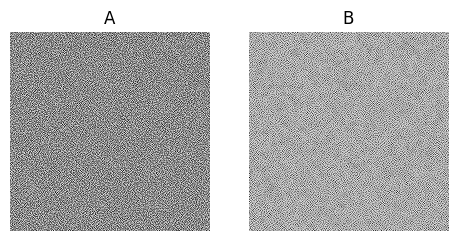

In [104]:
delta_t = 200.0

# simulation steps
N_simulation_steps = 1

DA, DB = 0.14, 0.06
f = 0.040128644555807114
k = 0.061836667358875275
for t in range(N_simulation_steps):
    A_check, B_check = gray_scott_update1(A_init, B_init, DA, DB, f, k, delta_t)

draw(A_check,B_check)

<Figure size 640x480 with 0 Axes>

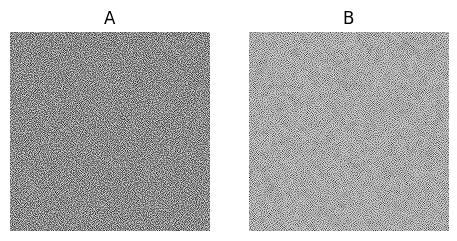

In [105]:
draw(A_target,B_target)

<Figure size 640x480 with 0 Axes>

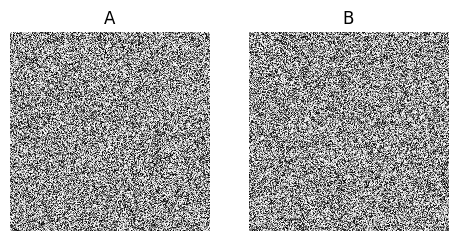

In [31]:
draw(A_init,B_init)